# Mutual Information


### ***Look into Bayesian analyses: given the score what are the chances of it being significant, i.e. not being a fluke?***

Mutual Information can be used for features selection. It is a great way of detecting non-linear relationship between
input and output of the data.

```
feature_selection.mutual_info_classif(X, y)	Estimate mutual information for a discrete target variable.
feature_selection.mutual_info_regression(X, y)	Estimate mutual information for a continuous target variable.
```

# TODO:
- [x] Need to find a more efficient way of calculating the mutual information  
- [x] Keep a dimension constant when calculating the mutual information, or at least group the calculations by time step, time step size will produce a certain number of trainable data.
- [x] Solving the confounder issue
     - Variables might be conditionally independent - e.g. $p(x,y|z)=p(x|z)p(y|z)$
      - We are measuring the dependence of x and y without looking at z, erroneously attributing 
- [ ] ~Filter out periodic signals and determine a ration between periodic and non periodic signals~
- [ ] Determine under which circumstances when we zoom in if we'll have enough data to train our networks
- [ ] ~Test if `mutual_info_classif~
- [x] **Normalise the MI as the percentage of information gained**
    - By normalising the MI by the mutual information of a RV with it self we can determine the information gain relative to the distribution of the cell. For example some cells have crime probability of 0.5 and others 0.1 which will lead to a low entropy to begin with. Using normalisation we can determine how much past events influence future ones relative to the cell's distribution. 
- [ ] Determine clusters where our model might perform better, solely due to the fact that the temporal clustering is occurring as well. This explains why, when looking at the map as a whole that the historic average models would out perform the neural networks - the average crime rate of areas that do not exhibit the self-exciting characteristics eclipse the areas that do. One would think that the neural networks would be able to learn which areas exhibit self-exciting characteristics and treat them differently while keep the base line crime rates for the cells that do not showcase these characteristics. We believe that there is not enough data for the models to approximate both types of cells and because we group both cells into one dataset the models might be getting stuck at a local optimum only approximating the historic average crime rates of the cells. Historic average might be more fitting named periodic average. 
- [ ] Rename historic average as the periodic average. 
- [ ] What is the threshold - if we can deconstruct a cell and see the distribution of influences: how much certain factors influences this specific cells we can start clustering the influential features so that we can classify the cells into certain types of cells. Cells that respond to crime differently and would therefore benefit by using certain models above other. An obvious way around this is by training each cell individually, therefore the models will not get too generalised. Training a model per cell might prove difficult without enough data.
- [x] Determine if the past events are relavant due to self-excitement or the periodic trend of crime, e.g. crime is more likely on weekends, thus looking at crime occurences a week ago will tell us indirectly if it is a weekday solely by the correlation between crime rate and the day of the week.
- [x] Explain how conditional mutual information allows us to remove/cater for the confounder variables.
- Problem: our data is too general and therefore not predictable enough???

Have joint pmf $\rightarrow$ be able to sum out certain variables to get the pmf for the variable alone.
- $I(X,Y) = H(X) + H(Y) - H(X,Y)$


Instead make use of conditional mutual information to take confounder variables into account :  
- $I(X_{1},\dots,X_{n+1}) = I(X_{1},\dots,X_{n})  - I(X_{1},\dots,X_{n}|X_{n+1})$


### Bayes' Rule for conditional entropy
- $H(Y|X)=H(X,Y)-H(X)$
- $H(X|Y)=H(X,Y)-H(Y)$

### Joint entropy
- $H(X_1,\dots,X_n)=-\sum_{i}p_{i}(X_1,\dots,X_n)*log_{2}(p_{i}(X_1,\dots,X_n))$

# 2020 version

#### Import optimisation: open code in PyCharm

In [3]:
import logging as log
import numpy as np
from utils.mutual_information import mutual_info as mi
from utils.utils import get_data_sub_paths
from utils.configs import BaseConf
from pprint import pprint
import os
from logger.logger import setup_logging
import torch
from utils.preprocessing import Shaper
from utils.utils import describe_array
import matplotlib.pyplot as plt
from sparse_discrete_table import *
from pprint import pprint
import numpy as np
from pprint import pformat

%matplotlib notebook
import pandas as pd

In [4]:
table = {
    (0,0):0.2,
    (0,1):0.3,
    (1,0):0.4,
    (1,1):0.1,        
}

rv = SparseDiscreteTable(rv_names=['x','y'],table=table)
rv_x_y = rv.conditional(rv_names_0=['x'],rv_names_condition=['y'])
rv_xy = rv_x_y*rv['y']
rv_xy,rv

# p(x,y)/p(y) = p(x|y)

(        
 ['x', 'y']        
 (0, 0): 0.2
 (0, 1): 0.3
 (1, 0): 0.4
 (1, 1): 0.1
         ,
         
 ['x', 'y']        
 (0, 0): 0.2
 (0, 1): 0.3
 (1, 0): 0.4
 (1, 1): 0.1
         )

In [5]:
sorted(get_data_sub_paths())

['T12H-X850M-Y880M_2013-01-01_2017-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2017-01-01',
 'T24H-X1275M-Y1320M_2012-01-01_2019-01-01',
 'T24H-X1700M-Y1760M_2012-01-01_2019-01-01',
 'T24H-X255M-Y220M_2013-01-01_2017-01-01',
 'T24H-X425M-Y440M_2012-01-01_2019-01-01',
 'T24H-X425M-Y440M_2013-01-01_2017-01-01',
 'T24H-X850M-Y880M_2012-01-01_2019-01-01',
 'T24H-X850M-Y880M_2013-01-01_2017-01-01',
 'T24H-X85M-Y110M_2013-01-01_2017-01-01',
 'T3H-X850M-Y880M_2013-01-01_2017-01-01',
 'T6H-X850M-Y880M_2013-01-01_2017-01-01']

In [6]:
def setup(data_sub_path):
    conf = BaseConf()

    conf.model_name = f"Mutual Info"

    conf.data_path = f"./data/processed/{data_sub_path}/"

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.data_path, exist_ok=True)
    os.makedirs(conf.model_path, exist_ok=True)
    
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)

    with np.load(conf.data_path + "generated_data.npz") as zip_file:  # context helper ensures zip_file is closed
        if conf.use_crime_types:
            sparse_crimes = zip_file["crime_types_grids"]
        else:
            sparse_crimes = zip_file["crime_grids"]

    shaper = Shaper(data=sparse_crimes,
                    conf=conf)
    
    return conf, shaper, sparse_crimes

In [7]:
log.info("test")

In [9]:
conf, shaper, sparse_crimes = setup("T24H-X850M-Y880M_2012-01-01_2019-01-01")#"T24H-X850M-Y880M_2013-01-01_2017-01-01")
squeezed_crimes = shaper.squeeze(sparse_crimes)
squeezed_crimes[squeezed_crimes > 0] = 1
# squeezed_crimes[squeezed_crimes > 40] = 40
squeezed_crimes = np.round(np.log2(1 + squeezed_crimes))
print(f"squeezed_crimes values =>{np.unique(squeezed_crimes)}")

squeezed_crimes values =>[0. 1.]


In [10]:
# discrete table
n, c, l = squeezed_crimes.shape
print(n,c,l)

2557 1 773


In [17]:
max_offset = 7
a = np.arange(20)
for k in reversed(range(max_offset)):
    print(a[k:-(max_offset-k)])

[ 6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [8]:
dow_n = np.arange(n)%7
dow_nc = np.expand_dims(dow_n,(1,2))
dow_ncl = np.ones((n,c,l))*dow_nc

In [9]:
data = np.concatenate([squeezed_crimes,dow_ncl],axis=1)

In [10]:
K = 4
rv_names = ['RV0_Ct','RV0_Dt','RV1_Ct-k','RV1_Dt-k'] # Ct: crime at t. Dt: day of week at t
mi_list = []
cmi_list = []
for i in range(l):
    if i % (l//10) == 0:
        print(f"{i+1}/{l} => {(i+1)/l*100}%")
    mi_list.append([])    
    cmi_list.append([])
    for k in range(0,K+1): # K is the maximum 
        if k == 0:
            joint = np.concatenate([data[:,:,i],data[:,:,i]],axis=1)
        else:
            joint = np.concatenate([data[k:,:,i],data[:-k,:,i]],axis=1)
        val,cnt = np.unique(joint,return_counts=True,axis=0)
        prb = cnt / np.sum(cnt)
        table = {}
        for k_,v_ in zip(list(map(tuple, val)),list(prb)):
            table[k_] = v_
        dt = SparseDiscreteTable(rv_names=rv_names,table=table)
        mi = dt.mutual_information(rv_names_0=['RV0_Ct'],
                                   rv_names_1=['RV1_Ct-k'])
        
        cmi = dt.conditional_mutual_information(rv_names_0=['RV0_Ct'],
                                                rv_names_1=['RV1_Ct-k'],
                                                rv_names_condition=['RV0_Dt','RV1_Dt-k'])
        
        if k == 0:
            if mi != dt['RV0_Ct', 'RV1_Ct-k'].entropy():        
                print("======================= error =======================")
                print(f"cmi, mi => {cmi,mi}")
                print(f"i, k => {i,k}")
        
        cmi_list[i].append(cmi)
        mi_list[i].append(mi)

1/773 => 0.129366106080207%
78/773 => 10.090556274256144%
155/773 => 20.051746442432083%
232/773 => 30.012936610608023%
309/773 => 39.974126778783955%
386/773 => 49.935316946959894%
463/773 => 59.89650711513583%
540/773 => 69.85769728331177%
617/773 => 79.81888745148771%
694/773 => 89.78007761966364%
771/773 => 99.74126778783958%


In [11]:
mi_arr = np.array(mi_list)
cmi_arr = np.array(cmi_list)
cmi_arr[:,0] - mi_arr[:,0]

array([-0.0031774 , -0.00299794, -0.00226055, -0.00357779, -0.00301566,
       -0.00506979, -0.0028506 , -0.0042639 , -0.00557822, -0.00298235,
       -0.00510537, -0.00497654, -0.00456536, -0.00433629, -0.0209934 ,
       -0.00533727, -0.00371146, -0.00341858, -0.00067676, -0.00259611,
       -0.00432879, -0.00631186, -0.00673975, -0.0056254 , -0.0078624 ,
       -0.00352823, -0.00152651, -0.00334146, -0.00619384, -0.00449172,
       -0.00727804, -0.00136701, -0.00509569, -0.0043301 , -0.00262262,
       -0.00683521, -0.00562513, -0.00575031, -0.00613264, -0.00569614,
       -0.00433665, -0.01040606, -0.00851186, -0.0014141 , -0.00292505,
       -0.00412112, -0.00338041, -0.00501478, -0.00473112, -0.00255102,
       -0.03246694, -0.00369248, -0.00331652, -0.00357492, -0.00235907,
       -0.00364129, -0.00357524, -0.00428007, -0.0069442 , -0.00942842,
       -0.00532375, -0.00319923, -0.00630589, -0.00739365, -0.00211765,
       -0.00613883, -0.00463449, -0.00311387, -0.00320839, -0.00

In [12]:
import matplotlib.cm as cm

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [13]:
%matplotlib notebook
def plot_top_n_mi_curves(mi_list, n=100):
    mi_arr = np.array(mi_list)
    #sorted_mi = mi_arr[np.argsort(mi_arr.sum(1))[::-1]]
    sorted_mi = mi_arr[np.argsort(mi_arr[:,1:].sum(1))[::-1]]
    plt.figure(figsize=(9.5,5))
    s_mi_mean = np.max(np.mean(sorted_mi,axis=1))

    sub_mi = sorted_mi[:n]
    mi_max = np.max(sub_mi[:,1:].mean(0)/sub_mi[:,:1].mean(0))
    mi_len = len(sub_mi)
    yticks = []
#     for i in range(mi_len):
#         y = sub_mi[i,1:]/sub_mi[i,0] # relative normalise mi
#         score = np.mean(y)/mi_max
#         x = np.arange(1,len(y)+1)
#         plt.plot(x,y,c=cm.winter(score),alpha=1)
    
    for i in range(1,n-20,10):
        y = sub_mi[:i+10,1:].mean(0)/sub_mi[:i+10,0].mean(0) # relative normalise mi
        
        y = moving_average(y,7)
        
        x = np.arange(1,len(y)+1)
        c_ = cm.winter_r(i/n)
        plt.plot(x,y,c=c_,alpha=0.8)    
    
    plt.grid()
    plt.xticks(range(1,len(y)+1),rotation=-60)
    # plt.yticks(yticks)
    plt.show()
    
plot_top_n_mi_curves(mi_list)
plot_top_n_mi_curves(cmi_list)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
np.shape(mi_list)

(773, 23)

In [75]:
def construct_mi_grid(mi_list):  
    """
    mi_list: shape (L,K+1) where L is the number of cells and K is the maxmimum time offset
             each value represents the mutual information between a cells crime at time t and t - k.   
             the first value in axis 1 is mi(crime at t, crime at t)
            
    mi_grid: return ndarray in the shape (1,K,H,W)
             where K is the max time offset
             each value is normalised occording to its own 
    """
    mi_arr = np.array(mi_list)
    self_mi_arr, mi_arr = mi_arr[:,:1] , mi_arr[:,1:]
    mi_arr = mi_arr/self_mi_arr
    mi_arr = np.swapaxes(mi_arr,0,1)
    mi_grid = shaper.unsqueeze(np.expand_dims(mi_arr,(0)))    
    return mi_grid

In [76]:
cmi_grid = construct_mi_grid(cmi_list)
mi_grid = construct_mi_grid(mi_list)

In [27]:
def interactive_mi_grid(mi_grid, crime_grid, is_conditional_mi=False):
    """
    crime_grid: crime counts N,C,H,W where N timesteps, C crime counts
    mi_grid: grid with shape 1,K,H,W where K is the max number of time offset    
    """
    _, _, n_rows, n_cols = mi_grid.shape

    fig = plt.figure(figsize=(9, 8))  # , constrained_layout=True)
    gs = fig.add_gridspec(2, 2)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, :])

    _img0 = ax0.imshow(mi_grid.mean(axis=(0, 1)))
    _img1 = ax1.imshow(crime_grid.mean(axis=(0, 1)))
    line, = ax2.plot([0], [0])

    ax1.set_title("Mean Crime Count")
    if is_conditional_mi:
        ax0.set_title("Conditional Mutual Information (CMI) Mean over Offset")
        ax2.set_title("CMI per Temporal Offset")
        ax2.set_ylabel("CMI - $I(C_{t},C_{t-k}|DoW_{t},DoW_{t-k})$")  # give I(C)
        ax2.set_xlabel("Offset in Days (k)")
    else:
        ax0.set_title("Mutual Information (MI) Mean over Offset")
        ax1.set_title("Crime Rate Grid")
        ax2.set_title("MI per Temporal Offset")
        ax2.set_ylabel("MI - $I(C_{t},C_{t-k})$")  # give I(C)
        ax2.set_xlabel("Offset in Days (k)")

    def draw(row_ind, col_ind):
        f = mi_grid[0, :, row_ind, col_ind]
        t = np.arange(1, len(f) + 1)  # start at one because offset starts at 1

        t_min = np.min(t)
        t_max = np.max(t)
        t_pad = (t_max - t_min) * 0.05
        t_min = t_min - t_pad
        t_max = t_max + t_pad

        f_min = np.min(f)
        f_max = np.max(f)
        f_pad = (f_max - f_min) * 0.05
        f_min = f_min - f_pad
        f_max = f_max + f_pad

        if t_min != t_max:
            ax2.set_xlim(t_min, t_max)
            ax2.set_xticks(t)
            ax2.grid(True)
        if f_min != f_max:
            ax2.set_ylim(f_min, f_max)
            
        line.set_data(t, f)
        fig.canvas.draw()

    def on_click(event):
        print(f"event => {pformat(event.__dict__)}")
        if hasattr(event, "xdata") and hasattr(event, "ydata"):
            if event.xdata and event.ydata:  # check that axis is the imshow
                row_ind = int(np.round(event.ydata))
                col_ind = int(np.round(event.xdata))
                draw(row_ind, col_ind)
        return True

    fig.canvas.mpl_connect('button_press_event', on_click)
    plt.show()

<IPython.core.display.Javascript object>


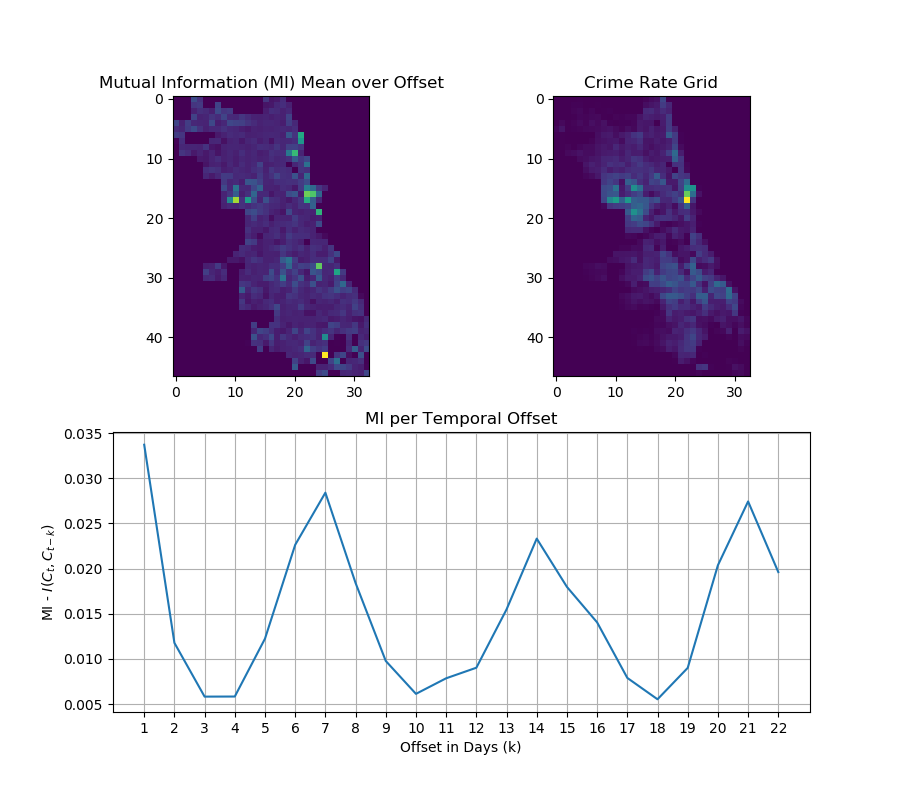

<IPython.core.display.Javascript object>


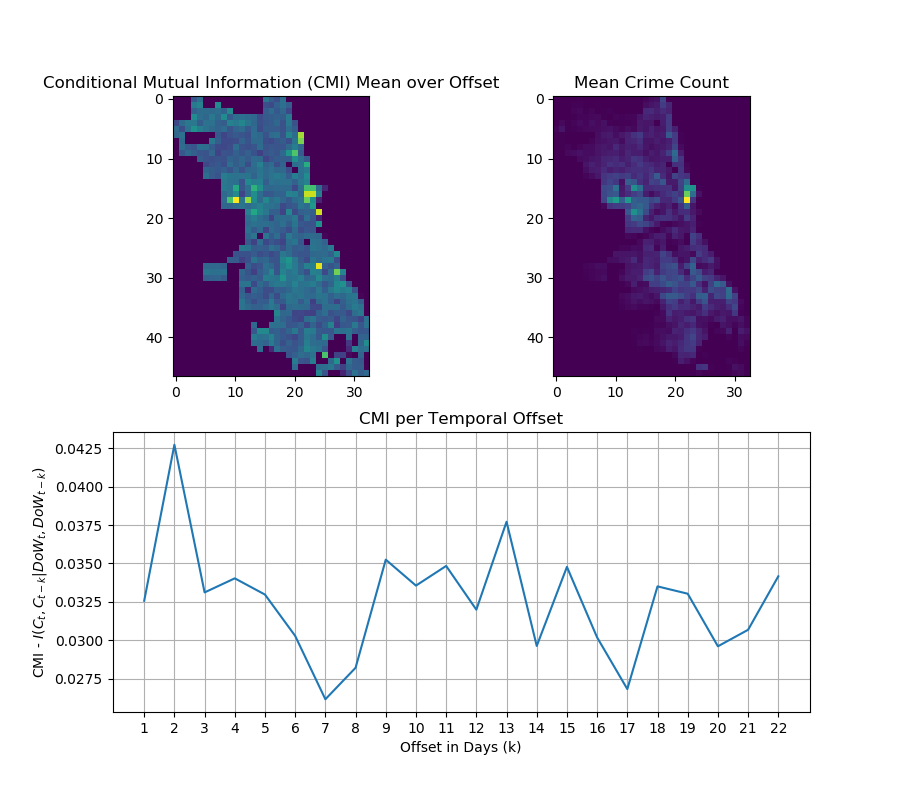

In [28]:
%matplotlib notebook
interactive_mi_grid(mi_grid=mi_grid, crime_grid=sparse_crimes,is_conditional_mi=False)
interactive_mi_grid(mi_grid=cmi_grid, crime_grid=sparse_crimes,is_conditional_mi=True)


T24H-X85M-Y110M_2013-01-01_2017-01-01
2020-04-06T08:21:16 | root | INFO | Device: cpu
./data/processed/T24H-X85M-Y110M_2013-01-01_2017-01-01/
____________________________________________________________
{'max': 0.9910024585010999,
 'mean': 0.001522268137667647,
 'min': 0.0,
 'shape': (21, 1, 376, 325),
 'std': 0.01668340708659274}
____________________________________________________________
____________________________________________________________
{'max': 0.3672571305891602,
 'mean': 0.000868674742077483,
 'min': 0.0,
 'shape': (20, 1, 376, 325),
 'std': 0.005337042433112124}
____________________________________________________________

T24H-X255M-Y220M_2013-01-01_2017-01-01
2020-04-06T08:24:28 | root | INFO | Device: cpu
./data/processed/T24H-X255M-Y220M_2013-01-01_2017-01-01/
____________________________________________________________
{'max': 0.9999239613741826,
 'mean': 0.005989956112975758,
 'min': 0.0,
 'shape': (21, 1, 188, 109),
 'std': 0.049918592828271234}
_______________

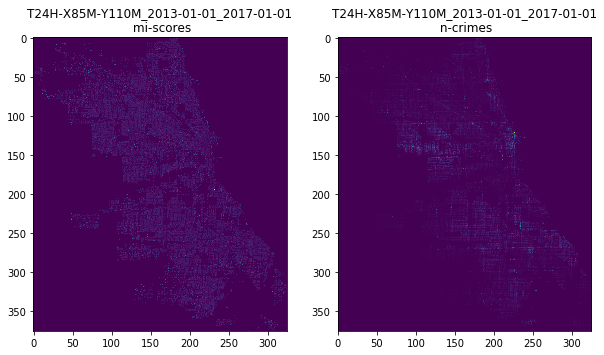

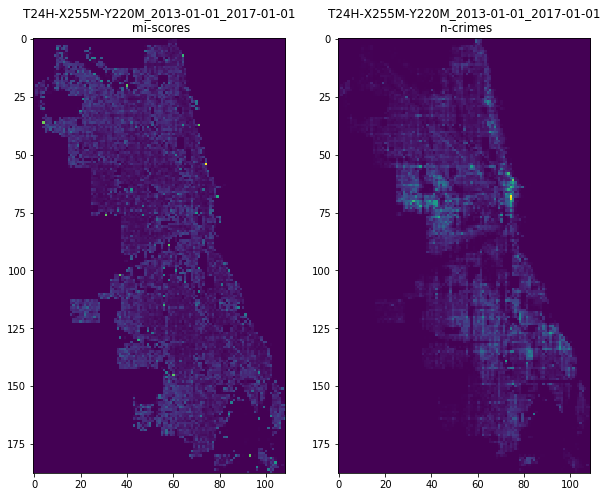

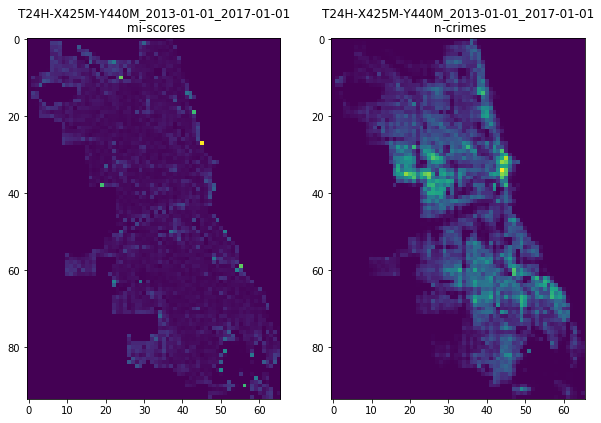

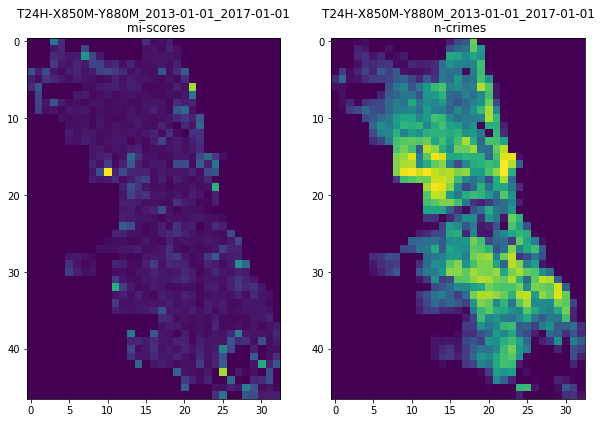

In [47]:
# data_sub_paths = get_data_sub_paths()
data_sub_paths = [
    'T24H-X85M-Y110M_2013-01-01_2017-01-01',
    'T24H-X255M-Y220M_2013-01-01_2017-01-01',
    'T24H-X425M-Y440M_2013-01-01_2017-01-01',
    'T24H-X850M-Y880M_2013-01-01_2017-01-01'
]

# data_sub_path = "T24H-X850M-Y880M_2013-01-01_2017-01-01"
# data_sub_path = "T24H-X425M-Y440M_2013-01-01_2017-01-01"
for data_sub_path in data_sub_paths:
    conf, shaper, sparse_crimes = setup()
    
    squeezed_crime = shaper.squeeze(sparse_crimes)[:,0,:]
    squeezed_crime[squeezed_crime > 0] = 1

    t_index = 0
    
    one_crimes = shaper.unsqueeze(np.expand_dims(squeezed_crime,axis=1))

    deltas = list(range(21))
    mi_score_list = []

    for delta in deltas:
        if delta != 0:
            future = squeezed_crime[delta:]
            past = squeezed_crime[:-delta]
        else:
            future = squeezed_crime
            past = squeezed_crime

        mi_score = mi(future,past,axis=t_index)
        mi_score_list.append(mi_score)

    mi_scores_stack = np.stack(mi_score_list)    

    M,L = mi_scores_stack.shape
    mi_scores = mi_scores_stack.reshape(M,1,L)

    # normalise the score over the actual cell counts
    normed_mi_scores = mi_scores[1:]/mi_scores[:1]


    normed_mi_scores = shaper.unsqueeze(normed_mi_scores)
    mi_scores = shaper.unsqueeze(mi_scores)

    print(describe_array(mi_scores))
    print(describe_array(normed_mi_scores))
    mi_grid = normed_mi_scores[1:,0].sum(0)  # todo compare toa grid witht the actual crime count
    a = mi_grid
    a -= a.min()
    a /= a.max()


    imshow_compare(a,one_crimes[:,0].sum(0),f"{data_sub_path}\n mi-scores",f"{data_sub_path}\n n-crimes")

# 2019

In [2]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, chi2
from sklearn.preprocessing import OneHotEncoder

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import pshape
from matplotlib import colors
from utils.plots import plot_dist
import pandas as pd

In [4]:
def norm_sum(x):
    return x/np.sum(x)

def norm_max(x):
    return x/np.max(x)


def entropy(x):
    return x*(-1)*np.log2(x)

In [5]:
def fuse_data(data_dict):
    """
    data_dict (keys): name of the data
    data_dict (values): name of the data
    """
    cols = []
    fields = []
    for k,v in data_dict.items():
        if v.shape[-1] > 1:
            cols.extend([f"{k}_{i}" for i in range(v.shape[-1])])
        else:
            cols.append(k)

        fields.append(v)
    X = np.hstack(fields)
    
    return X, cols

In [21]:
# making a joint table
def joint(X, cols=None):
    """
    create joint pmf 
    X: samples (n_samples, n_feats)
    cols: names/aliases of column features [optional]
    """
    values, counts = np.unique(ar=X,
                          return_counts=True,
                          axis=0)

    probs = counts/np.sum(counts)
    if cols is None:
        cols = [f"rv{i}"for i in range(values.shape[-1])]
        
    pmf = pd.DataFrame(values, columns=cols)
    pmf["p"] = probs
    pmf = pmf.sort_values('p',ascending=False)
    return pmf

def h(df):
    """
    entropy using log base 2
    """
    p = df["p"]
    return (-1)*np.sum(p*np.log2(p))

def marg(pmf, keep_var):
    """
    keep_var is a list of variable names we do not want summed out
    """
    a = pmf[[*keep_var,"p"]].groupby(keep_var,as_index=False).sum()
    return a

In [26]:
dist(X[:,1]),rv0

((array([0, 1]), array([0.22, 0.78])),    rv0     p
 0    0  0.22
 1    1  0.78)

In [23]:
X = np.random.binomial(1,.7,(100,2))
pmf = joint(X)
rv0 = marg(pmf,["rv0"])
rv1 = marg(pmf,["rv1"])
rv01 = marg(pmf,["rv0", "rv1"])
rv1["p"].sum()
pmf

,rv0,rv1,p
3,1,1,0.57
1,0,1,0.21
2,1,0,0.21
0,0,0,0.01


In [11]:
m01 = marg(pmf, ["rv0","rv1"])
m0 = marg(pmf, ["rv0"])
m1 = marg(pmf, ["rv1"])
mi = h(m1) + h(m0) - h(m01)
mi

0.00034894444383093415

In [12]:
def plot_mi(X,y):
    mi = mutual_info_classif(X,y, discrete_features=True)
    figsize=(20,5)
    plt.figure(figsize=figsize)
    plt.imshow(np.array([mi]),aspect=20*figsize[1]/figsize[0], vmin=0,vmax=np.max(mi))
    plt.colorbar()
    plt.show()
    
    figsize=(20,5)
    plt.figure(figsize=figsize)
    plt.plot(mi)
    plt.show()

In [13]:
def dist(a, plot=False):

    v,c = np.unique(a.flatten(),return_counts=True)
    c = c/np.sum(c)

    if plot:
        plt.stem(v,c, use_line_collection=True,markerfmt="x",basefmt=".")
        plt.grid()
        plt.show()
    
    
    return v,c

def dists(*args):
    for a in args:
        _ = dist(a)

In [14]:
# squeeze into (N,1,L)
# get MI for each L give the past n steps.

In [28]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer, get_data_sub_paths, pshape, get_data_resolutions
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup

from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models,\
                                get_models_metrics, get_models_results
from pprint import pprint
from time import time

In [30]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))
data_sub_path = 'T24H-X850M-Y880M_2013-01-01_2017-01-01'


conf = BaseConf()

conf.use_historic_average = True 
conf.use_classification = True
conf.use_crime_types = True

conf.seed = 3#int(time())  # idea is to have a constant seed while changing hyperparameters

conf.pad_with = 1 
conf.seq_len = 1

conf.model_name = f"Mutual Info"

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path,
              log_config='./logger/standard_logger_config.json',
              default_level=log.INFO)

# SET NUMPY AND TORCH SEEDS LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")

conf.device = device

# SET THE hyperparameterS
conf.resume = False
conf.early_stopping = False
conf.max_epochs = 120
conf.dropout = 0#0.2
conf.weight_decay = 0#1e-8
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 4e-3
conf.batch_size = 64

# CRIME DATA
conf.sub_sample_test_set = 0
conf.sub_sample_train_set =  0 # 0 #
conf.sub_sample_validation_set = 0 # 0 #

2019-12-12T07:35:35 | root | INFO | Device: cpu


```
data_group = CellDataGroup(data_path=conf.data_path, conf=conf)
loaders = CellDataLoaders(data_group=data_group, conf=conf)
conf.freqstr = data_group.t_range.freqstr  

def get_input_features(batch_loader, conf):
    probas_pred = np.zeros(batch_loader.dataset.target_shape, dtype=np.float)
    y_true = batch_loader.dataset.targets[-len(probas_pred):]
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]

    with torch.set_grad_enabled(False):
        model.eval()

        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch
            
            # reformat for model input
            tmp_feats = np.swapaxes(tmp_feats,0,1)
            tmp_feats = np.reshape(tmp_feats, (tmp_feats.shape[0],-1))
            spc_feats = spc_feats[-1]
            env_feats = env_feats[-1]
            cmp_feats = np.concatenate((spc_feats,tmp_feats,env_feats),axis=-1)
            targets = targets[-1, :, 0]                        

            # Transfer to PyTorch Tensor and GPU
            cmp_feats = torch.Tensor(cmp_feats).to(conf.device)
                                     
            # used for log_reg_3
            spc_feats = torch.Tensor(spc_feats).to(conf.device)  
            tmp_feats = torch.Tensor(tmp_feats).to(conf.device)  
            env_feats = torch.Tensor(env_feats).to(conf.device)  

            out = model(cmp_feats)
#             out = model(tmp_feats)
#             out = model(env_feats)
#             out = model(spc_feats=spc_feats,
#                         tmp_feats=tmp_feats,
#                         env_feats=env_feats)
            
            if conf.use_classification:
                batch_probas_pred = F.softmax(out, dim=-1)[:, 1].cpu().numpy()  # select class1 prediction
            else:
                batch_probas_pred = out.cpu().numpy()

            for i, p in zip(indices, batch_probas_pred):
                n, c, h, w = i
                probas_pred[n, c, h, w] = p

    return y_true, probas_pred, t_range
    
    
```    

In [31]:
from utils.preprocessing import Shaper
from utils.data_processing import sequencify
from models.baseline_models import HistoricAverage

In [32]:
def describe(*A):
    for a in A:
        v,c = dist(a)
        d = {
            "min":np.min(a),
            "max":np.max(a),
            "mean":np.mean(a),
            "std":np.std(a),
#             "median":np.median(a),
            "shape":np.shape(a),
            "nunique":len(np.unique(a)),
            # dist becomes an issue with continuous variables
#             "dist": dict(
#                 zip(v,c))
        }

        pprint(d)
        print("____________________________________________________________")

In [33]:
conf.use_crime_types=False

with np.load(conf.data_path + "generated_data.npz") as zip_file:  # context helper ensures zip_file is closed
    if conf.use_crime_types:
        crimes = zip_file["crime_types_grids"]
    else:
        crimes = zip_file["crime_grids"]
        
print(conf.data_path)        

./data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/


In [34]:
log_floor_crimes = np.floor(np.log2(1 + crimes))

conf.shaper_threshold = 0
conf.shaper_top_k = -1

shaper = Shaper(data=log_floor_crimes,
                conf=conf)
X_reg = shaper.squeeze(log_floor_crimes)  # crime counts scaled and discretised

X_clf = np.copy(X_reg) # crime=1 no_crime=0
X_clf[X_clf > 0] = 1

max_steps = -1


ha = HistoricAverage()
ha.fit(X_reg)
ha.max_steps = max_steps
X_ha = ha.transform(X_reg)

X_reg = X_reg[max_steps+1:]

X_clf = X_clf[max_steps+1:]

X_ha = X_ha[max_steps+1:]
# X_ha = np.round(X_ha)  # ensures we still work in discrete values

sorted_indices = np.argsort(X_reg[:,0].mean(0))[::-1]

describe(X_clf,X_reg)

fitted historic average: step (1) and max_steps (-1)
{'max': 1.0,
 'mean': 0.4199533288648204,
 'min': 0.0,
 'nunique': 2,
 'shape': (1461, 1, 772),
 'std': 0.4935509400661459}
____________________________________________________________
{'max': 5.0,
 'mean': 0.5065210144233667,
 'min': 0.0,
 'nunique': 6,
 'shape': (1461, 1, 772),
 'std': 0.6569848748518736}
____________________________________________________________


In [35]:
dist(X_reg)

(array([0., 1., 2., 3., 4., 5.]),
 array([5.80046671e-01, 3.37589947e-01, 7.82175953e-02, 4.09259043e-03,
        4.78769244e-05, 5.31965827e-06]))

In [36]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_ha_disc = discretizer.fit_transform(X_ha.reshape(((-1,1))))
X_ha_disc = X_ha_disc.reshape(X_ha.shape)

In [37]:
dist(X_ha_disc)

(array([0., 1., 2., 3., 4.]),
 array([0.19999344, 0.19999699, 0.20000585, 0.20000142, 0.20000231]))

In [38]:
a = {
    "X_ha_disc":X_ha_disc.reshape((-1,1)),
    "X_clf":X_clf.reshape((-1,1)),
    }

fields, cols = fuse_data(a)
pmf = joint(fields,cols)
p_X_ha_disc = marg(pmf,["X_ha_disc"])
p_X_clf = marg(pmf,["X_clf"])

h(p_X_clf) + h(p_X_ha_disc) - h(pmf)



0.23458515993938578

In [39]:
mutual_info_classif(X_ha_disc.reshape((-1,1)),X_clf.reshape((-1,1))[:,0],discrete_features=True)

array([0.16260204])

In [40]:
pshape(X_ha_disc,X_ha)

(1461, 1, 772)
(1461, 1, 772)


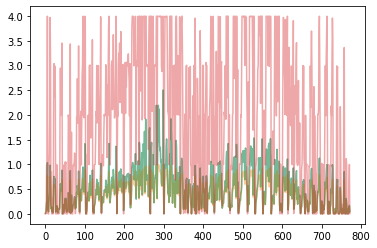

In [41]:
def p(a):
    plt.plot(a,alpha=.4)

p(X_ha.mean(0)[0])
p(X_clf.mean(0)[0])
p(X_ha.mean(0)[0])
p(X_ha_disc.mean(0)[0])

In [42]:
X = X_ha_disc.reshape((-1,1))
y = X_clf.reshape((-1,1))[:,0]
mutual_info_classif(X,y,discrete_features=True)

array([0.16260204])

In [43]:
X = X_clf.reshape((-1,1))
y = X_ha_disc.reshape((-1,1))[:,0]
mutual_info_classif(X,y,discrete_features=True)

array([0.16260204])

In [44]:
X = X_ha_disc.reshape((-1,1))
y = X_ha_disc.reshape((-1,1))[:,0]
mutual_info_classif(X,y,discrete_features=True)

array([1.60943791])

In [45]:
n = 5
np.log(n)

1.6094379124341003

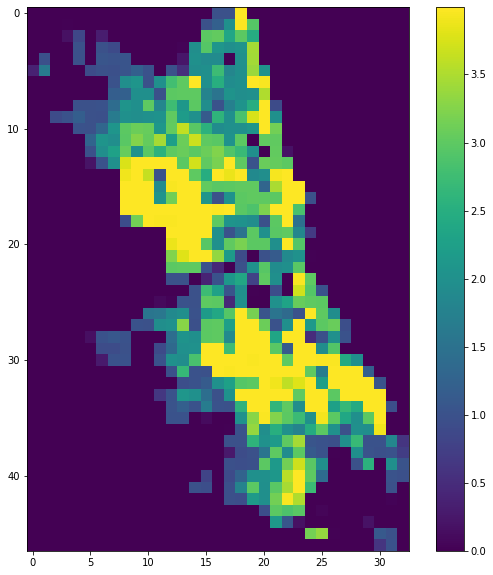

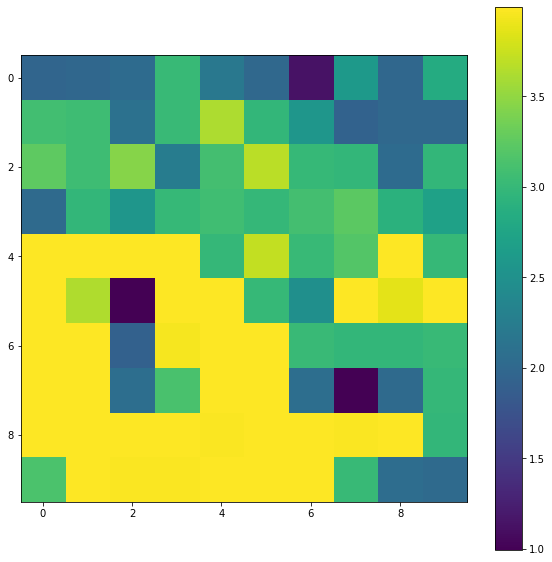

In [46]:
xx = X_ha_disc
im(shaper.unsqueeze(xx).mean(0)[0])
im(shaper.unsqueeze(xx)[:,:,9:19,9:19].mean(0)[0]) # try all models on only this data...

- Getting mutual infomation for each cell across grid
- Need to get the input and target vector - get this by the offset in time
- get the joint pmf of these values
- Do we predict the probability function of any cell over the map, i.e. random variable represents any and all cells.

Troubles we current face analysing the mutual information of data is that entropy is dependent on the distribution of the cell. Due to cells being disproportionately distrobuted we have quite low entropy and either ends (0.05 and 0.95 probabilities). Therefore the maximum increase 


Writing down thought on the project.
- Give a series of datapoints, predict the crime rate at that specific time, that is esentialy what the Hawkes process does on a continous level. We represents the integral of intensity function over a certain crime as the expected amount of crime for that length of crime. We want to be able to correctly predict the crime rate for that speific cell in time and space. In our case it happens that the historic average does a very good job of representing that probability function. We can measure the self influence the average cell has on itself as well as targetting a specific cell. By measuring the mutual information between a cells crime rate and a past rate we can determine level of dependency between the two. We can also add an extra field to the joint probabilty mass function we are using to calculate the mutual information to determine how much of contribution the new field has on future crime.

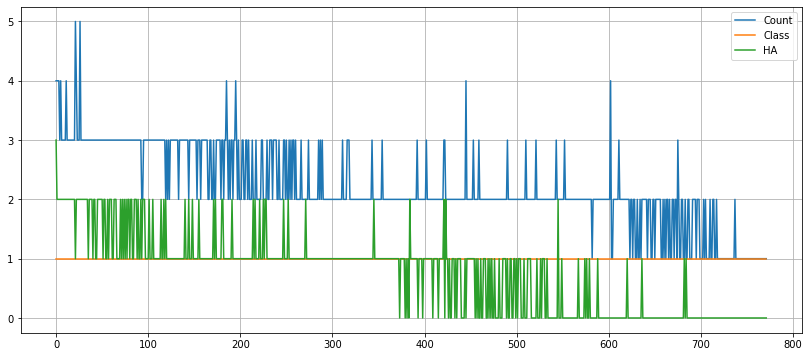

In [47]:
plt.figure(figsize=(14,6))
plt.plot(X_reg.max(0)[0,sorted_indices],label="Count")
plt.plot(X_clf.max(0)[0,sorted_indices],label="Class")
plt.plot(np.round(X_ha).max(0)[0,sorted_indices],label="HA")
plt.grid()
plt.legend()
plt.show()

In [48]:
# doing it for the general case is easy - overall cells
t = 1
x = X_clf[:,0]
y = x[t:]
x = x[:-t]

x = np.expand_dims(x.flatten(),axis=-1)
y = y.flatten()

cross_mi = mutual_info_classif(x,y,discrete_features=True)
self_mi = mutual_info_classif(x,x[:,0],discrete_features=True)
print(f"cross_mi: {cross_mi}")
print(f"self_mi: {self_mi}")

cross_mi: [0.05182226]
self_mi: [0.68027957]


In [49]:
_,p= dist(x)
np.sum(-1*p*np.log(p))

0.6802795686894603

In [84]:
def get_mi(t,offset=1,normed=False):
    """
    t should be 1d array shape (n,)
    """
    x = np.reshape(t[:-offset],(-1,1))
    y = np.reshape(t[offset:],(-1,1))

    joint_data,cols = fuse_data({
        "x":x,
        "y": y,
    })
    
    p_xy = joint(joint_data,cols=cols)
    p_x = marg(p_xy,['x'])
    p_y = marg(p_xy,['y'])
   
    h_xy = h(p_xy)
    h_x = h(p_x)
    h_y = h(p_y)
    
    
    if normed:
        mi = h_x + h_y - h_xy
    else:
        mi = 1 + (h_x - h_xy)/h_y        
    
    return mi

T = 14
mis_normed = np.zeros((T,1,X_clf.shape[-1]))
mis = np.zeros((T,1,X_clf.shape[-1]))
for offset in range(1,1+T):
    print(f"offset {offset}")
    for i in range(X_clf.shape[-1]):
        mi_normed = get_mi(t=X_clf[:,0,i],offset=offset,normed=True)
        mis_normed[offset-1,0,i] = mi_normed

        mi = get_mi(t=X_clf[:,0,i],offset=offset,normed=False)
        mis[offset-1,0,i] = mi

offset 1
offset 2
offset 3
offset 4
offset 5
offset 6
offset 7
offset 8
offset 9
offset 10
offset 11
offset 12
offset 13
offset 14


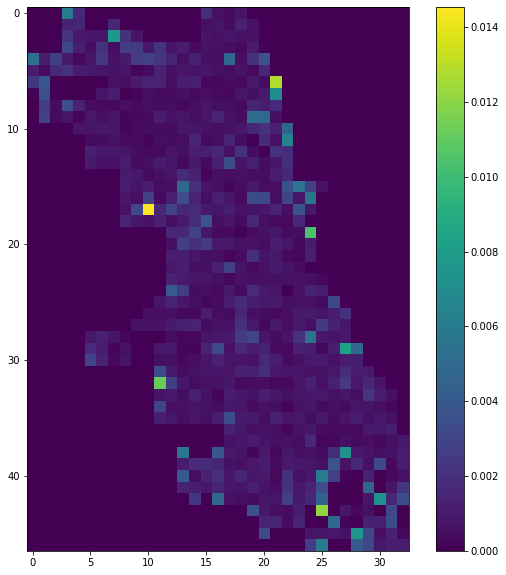

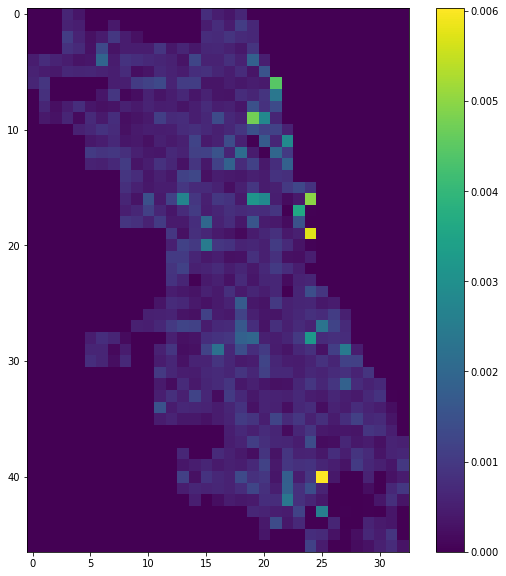

In [92]:
# todo get h map too
mis = np.expand_dims(mis.mean(0),0)
mis_normed = np.expand_dims(mis_normed.mean(0),0)

im(shaper.unsqueeze(mis)[0,0])
im(shaper.unsqueeze(mis_normed)[0,0])

In [ ]:
# optimized looping
mis_t = []



for i in range(X_clf.shape[-1]):  # loop per cell
    for offset in range(1,28):  # same cell dif
        mis = []

        X = np.reshape(X_clf[:-offset,0,i].flatten(),(-1,1))
        y = X_clf[offset:,0,i].flatten()
        
        # get joint
        # marg one
        # marg the other
        
        # Y is target distribution
        # I(X,Y) = H(X) + H(Y) - H(X,Y)
        # self(Y,Y) = H(Y) + H(Y) - H(Y,Y) = H(Y) + H(Y) - H(Y) = H(Y)
        # normedI(X,Y) = (H(X) + H(Y) - H(X,Y))/H(Y)
        

        mi = mutual_info_classif(X,y,discrete_features=True) # uses log not log2
        mis.append(mi)
    mis_t.append(mis)
    
    
# todo swap axis of everyth    
mis_t = np.array(mis_t)[:,:,0]    

In [52]:
mis_t = []

for offset in range(1,28):
    mis = []
    for i in range(X_clf.shape[-1]):
        X = np.reshape(X_clf[:-offset,0,i].flatten(),(-1,1))
        y = X_clf[offset:,0,i].flatten()

        mi = mutual_info_classif(X,y,discrete_features=True) # uses log not log2
        mis.append(mi)
    mis_t.append(mis)
    
mis_t = np.array(mis_t)[:,:,0]    

In [53]:
new_mis_grid = np.zeros((mis_t.shape[0]+1,mis_t.shape[1]+1))

new_mis_grid[0,1:] = mis_t.mean(0)
new_mis_grid[1:,0] = mis_t.mean(1)
new_mis_grid[1:,1:] = mis_t

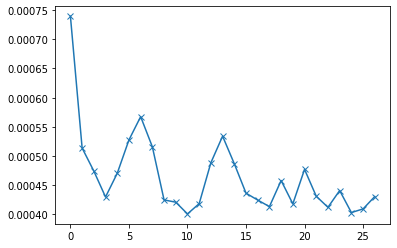

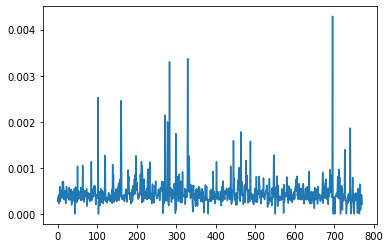

In [54]:
plt.plot(mis_t.mean(1),marker="x")
plt.show()
plt.plot(mis_t.mean(0))
plt.show()

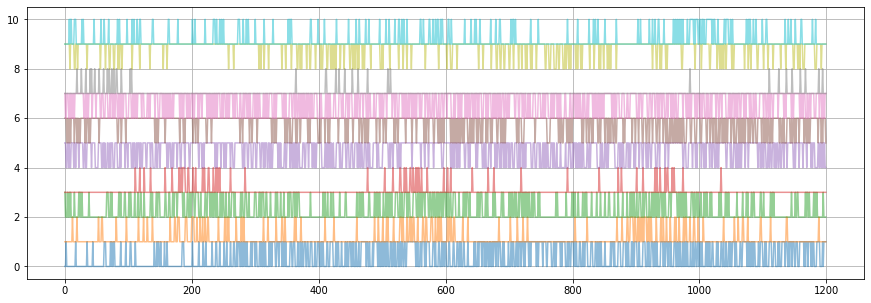

In [65]:
top_mi = np.argsort(mis_t.mean(0))[::-1][:]

plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(i+X_clf[:1200,0,top_mi[i]],alpha=0.5)
plt.grid()
plt.show()

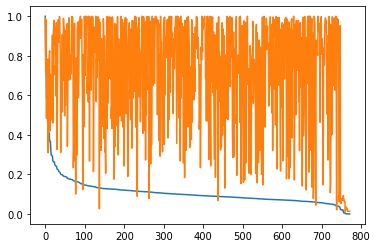

In [66]:
lim = 1000

plt.plot(norm_max(mis_t.mean(0)[top_mi[:lim]]))
plt.plot(norm_max(entropy(X_clf.mean(0)[0,top_mi[:lim]])))

In [67]:
from scipy.ndimage.filters import gaussian_filter1d

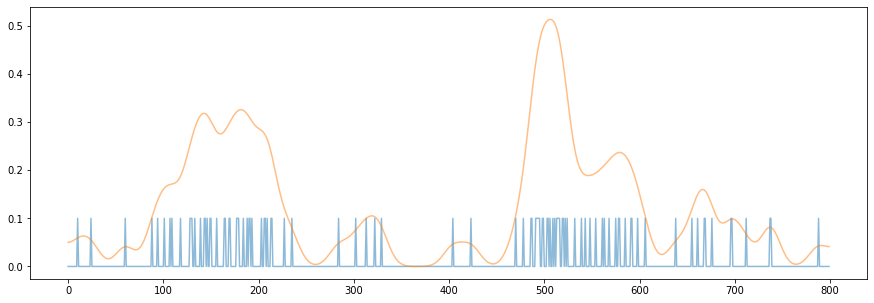

In [68]:
y = X_clf[400:1200,0,top_mi[1]]
plt.figure(figsize=(15,5))
plt.plot(.1*y,alpha=0.5)
plt.plot(gaussian_filter1d(y,10),alpha=0.5)
plt.show()

In [78]:
X_clf.shape

(1461, 1, 772)

### Top 10 cells with highest MI over time

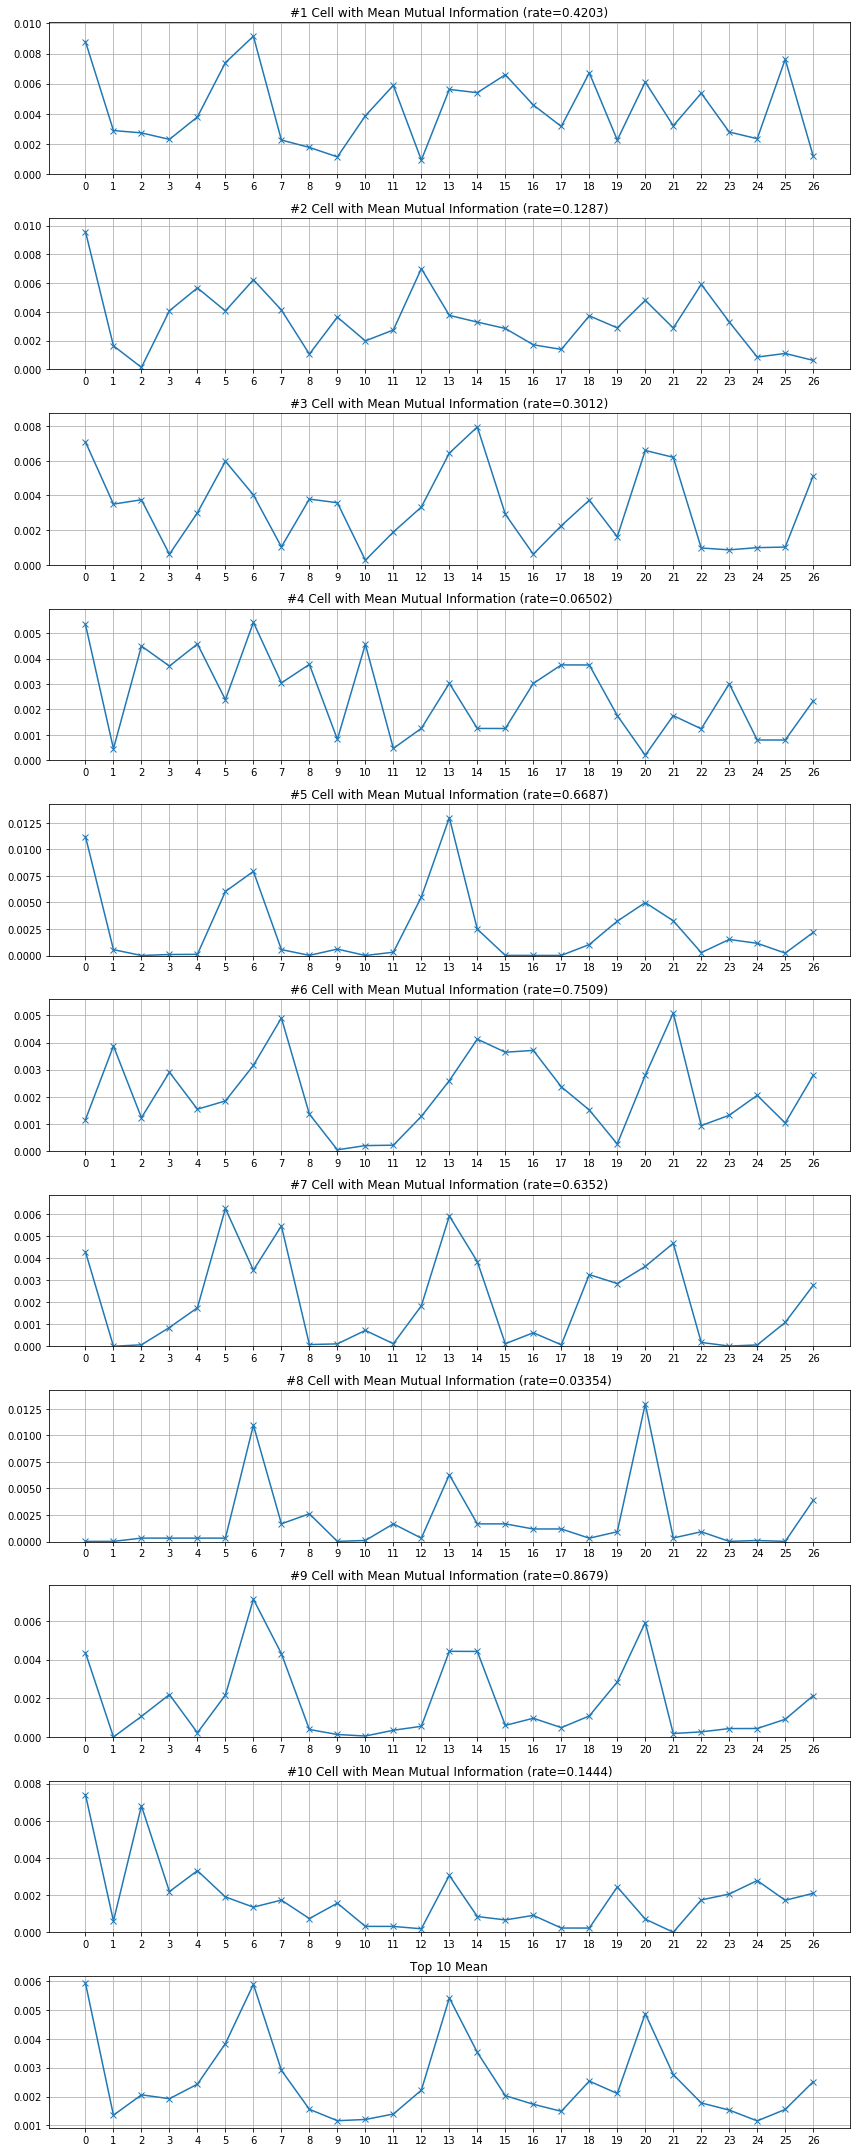

In [80]:
n = 10
step = 1
f,ax = plt.subplots(nrows=n+1,ncols=1)
f.set_figheight(3*n)
f.set_figwidth(12)
for i in range(n):
    y = mis_t[:,top_mi[i]]
    crime_rate = X_clf[:,0,top_mi[i]].mean()
    ax[i].set_title(f"#{i+1} Cell with Mean Mutual Information (rate={crime_rate:.4})")
    ax[i].plot(y,marker="x")
    ax[i].set_xticks(np.arange(0,len(y),step))
    ax[i].grid(True)
    ax[i].set_ylim(0,1.1*np.max(y))
# mean plot

ax[n].set_title(f"Top {n} Mean")
y = mis_t[:,top_mi[:n]].mean(1)

ax[n].plot(y,marker="x")
ax[n].set_xticks(np.arange(0,len(y),step))
ax[n].grid(True)
plt.tight_layout()
plt.show()

In [70]:
X_mi_t = np.expand_dims(mis_t,axis=1)

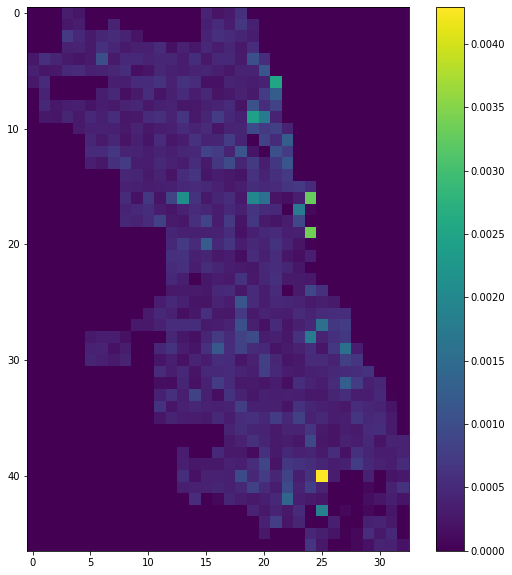

In [71]:
y = shaper.unsqueeze(X_mi_t).mean(0)[0]
im(y)

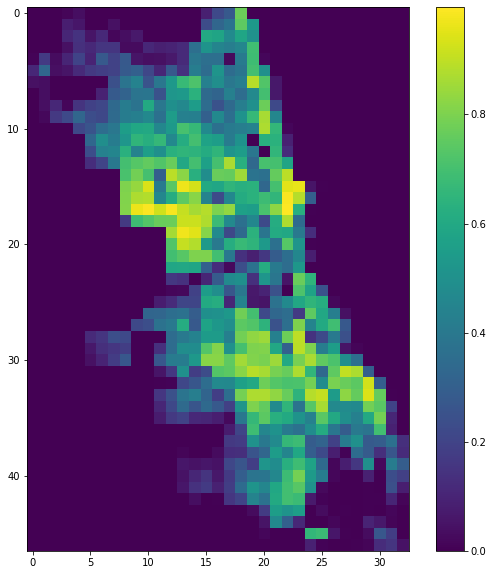

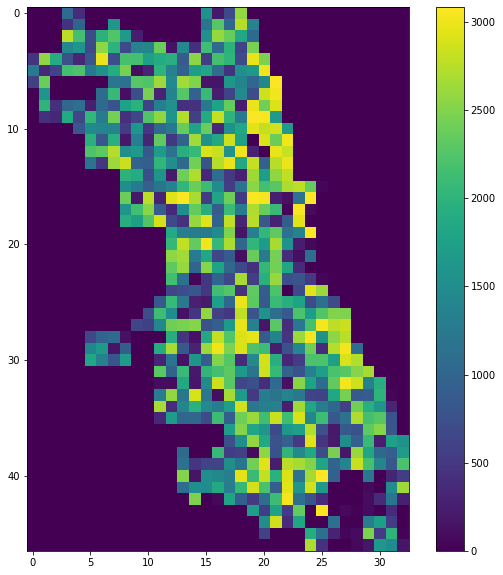

In [72]:
im(shaper.unsqueeze(X_clf).mean(0)[0])
for i in range(1):
    top_mi = np.argsort(mis_t.mean(0))[::-1][:]
    X_top_mi = np.zeros_like(X_clf)
    X_top_mi[:,0,top_mi] = np.arange(len(top_mi))[::-1]
    im(shaper.unsqueeze(4*X_top_mi+X_clf).mean(0)[0])

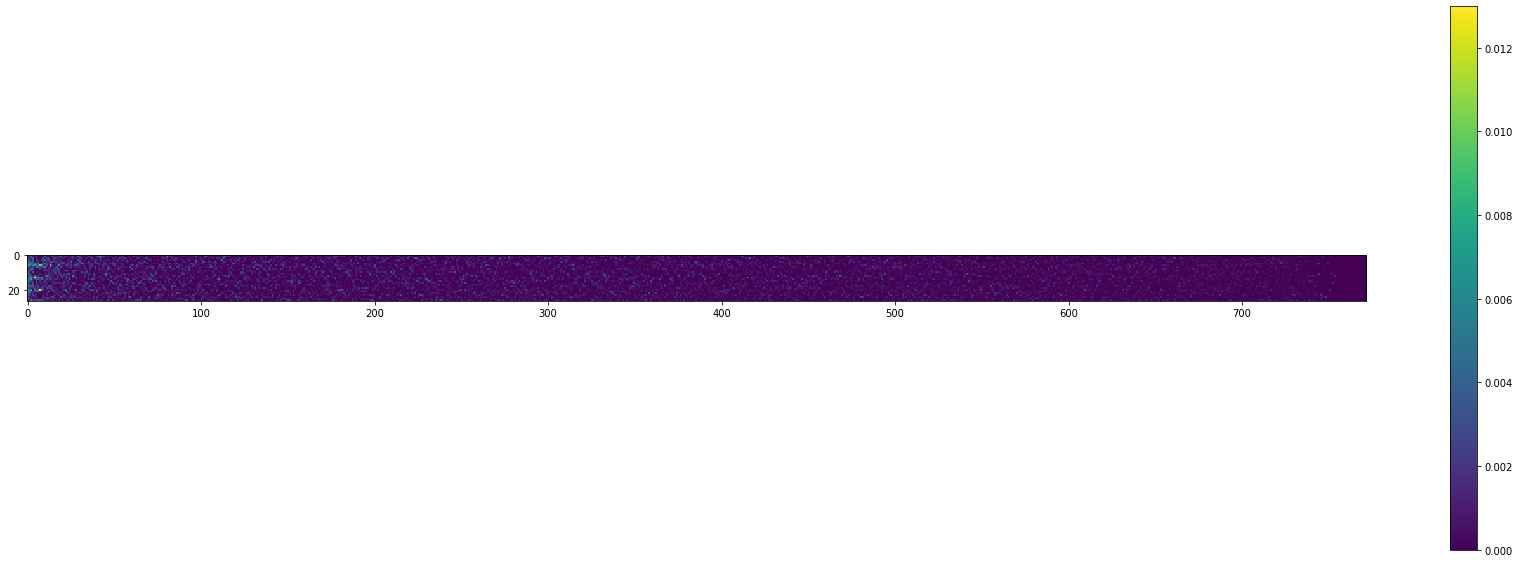

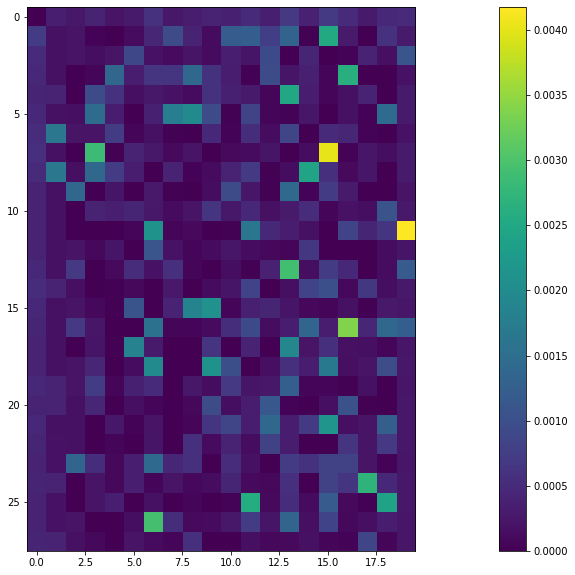

In [73]:
im(mis_t[:,top_mi],figsize=(30, 10),aspect=1)
im(new_mis_grid[:,:20],figsize=(30, 10),aspect=1)

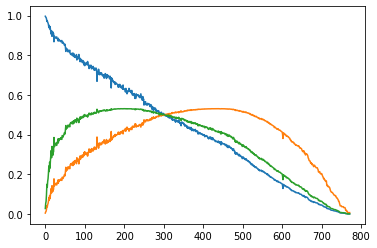

In [74]:
xx = X_clf.mean(0)[0][sorted_indices]


plt.plot(xx)
plt.plot(entropy(xx))
plt.plot(entropy(1-xx))


In [75]:
X = np.reshape(X_ha[:-1].flatten(),(-1,1))
y = X_clf[1:].flatten()

mutual_info_classif(X,y,discrete_features=True)

array([0.38275058])

In [ ]:
describe(X,y)

In [ ]:
lim = 40
n = 30


plt.plot(1+X_ha[:lim,0,sorted_indices[n]])
plt.plot(X_reg[:lim,0,sorted_indices[n]])

In [ ]:
# historic average
ha = HistoricAverage(max_steps=7)
ha.fit(X_reg)

lim = 100

plt.figure(figsize=(15,5))

for max_steps in [1]:
    ha.max_steps = max_steps
    X_ha = ha.transform(X_reg)
    plt.plot(X_ha.mean(-1)[:lim],alpha=0.3,label=f"{max_steps}")

plt.plot(X_reg.mean(-1)[:lim],alpha=0.3,label="original")
plt.grid()
plt.legend()
plt.show()

In [ ]:
np.sum(X_reg[10:]-X_ha[10:])



In [ ]:
# construct X and y for the mi calculations
max_offset = np.max(X_reg)

plt.figure(figsize=(10,50))
for offset, index in enumerate(sorted_indices[::len(sorted_indices)//40]):
    x = X_reg[:100,0,index]
    plt.plot(x+offset*max_offset)
plt.yticks(np.arange(offset)*max_offset)    
plt.grid()
plt.show()


In [ ]:
# shaper can filer out dead cells based on the variance?
conf.data_path

In [ ]:
def plot_seq(a):
    plt.figure(figsize=(15,5))
    plt.plot(a)
    plt.grid()
    plt.show()

In [ ]:
X_stack = []
y_stack = []

for i in sorted_indices[:]:#range(len(sorted_indices)):
    seq = X_reg[:,0,i]

    seq_len = 100

    sequences = sequencify(seq,seq_len=seq_len+1)  # shape -> (N-seq_len, seq_len)
    X, y = sequences[:,:], np.copy(sequences[:,-1])
    # add al zero column
    n_samples,n_feats = X.shape
    new_X = np.zeros((n_samples,n_feats+2))
    new_X[:, 2:] = X
    new_X[:, 0] = np.random.randint(0, len(set(X.flatten())), size=len(X))

    X = new_X
    y[y > 0] = 1
    
    X_stack.append(X)
    y_stack.append(np.reshape(y,(-1,1)))
    
X = np.vstack(X_stack)
y = np.vstack(y_stack)[:,0]    

In [ ]:
pshape(X,y)
mi = mutual_info_classif(X,y,discrete_features=True)
# mi = mutual_info_regression(X,y)
mi = mi/np.max(mi)

In [ ]:
print(conf.data_path)

plt.figure(figsize=(15,7))
plt.stem(mi[::-1], use_line_collection=True,markerfmt="x",basefmt=".")
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()

plt.figure(figsize=(15,7))
plt.stem(mi[:-1][::-1], use_line_collection=True,markerfmt="x",basefmt=".")
plt.stem([len(mi)-3,len(mi)-2],mi[:-1][::-1][-2:], use_line_collection=True,linefmt="r",markerfmt="rD",basefmt=".")
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()

print()
plt.figure(figsize=(15,7))
plt.plot(mi[2:-1][::-1])
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()


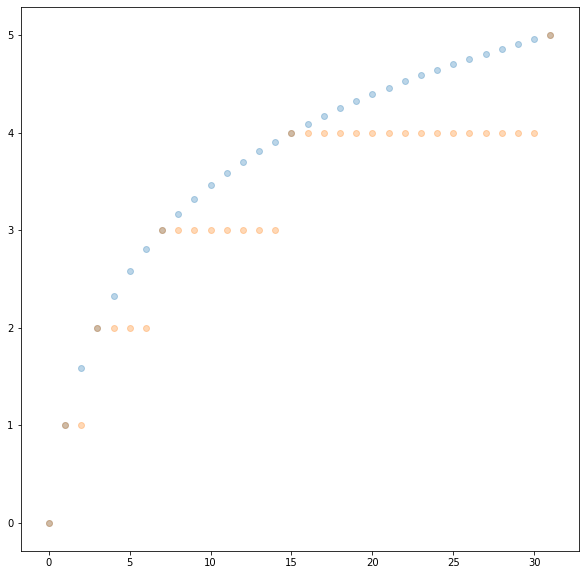

In [104]:

x = np.arange(32)
x_log = np.log2(1 + x)
x_log_round = np.floor(x_log)

plt.figure(figsize=(10,10))
# plt.scatter(x,x,alpha=.3,label="x")
plt.scatter(x,x_log,alpha=.3,label="log(x)")
plt.scatter(x,x_log_round,alpha=.3,label="round(log(x))")
plt.show()
